# The aim of this file is to inspect the behavior of the NN's params with respect to the gradient of the cost function w.r.t. u and $\delta$

In [1]:
import json
import warnings
import os, subprocess, sys
import time
from typing import Optional, Callable, Tuple, Dict, List

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.io
from scipy.linalg import solve_continuous_are
from scipy.special import softmax
import seaborn as sns

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.tensorboard import SummaryWriter
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    warnings.warn("PyTorch not available. GPU training will not be available.")
    
from ocslc.switched_linear_mpc import SwitchedLinearMPC as SwiLin_casadi

from src.switched_linear_torch import SwiLin
from src.training import SwiLinNN

## Set environment variables

In [ ]:
# Global settings
N_PHASES = 10
TIME_HORIZON = 1.0

# NN settings
N_CONTROL_INPUTS = 1
N_STATES = 3
N_NN_INPUTS = 3
N_NN_OUTPUTS = N_PHASES * (N_CONTROL_INPUTS + 1)  # +1 for the mode

# Casadi settings
MULTIPLE_SHOOTING = True
INTEGRATOR = 'exp'
HYBRID = False
PLOT = 'display'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Interpretability Analysis

Now we perform interpretability analysis on the trained policy $y = f_\theta(x_0)$. Since the policy directly maps initial states to control sequences and mode durations, we focus on:

1. **Local sensitivity**: $\frac{\partial u}{\partial x_0}$ and $\frac{\partial \tau}{\partial x_0}$
2. **Integrated gradients** and smoothgrad on $x_0$
3. **Mode duration analysis**: Which state components drive which mode durations

This analysis doesn't require environment gradients—it's purely differentiating the network mapping.

In [3]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load trained model
trained_network = SwiLinNN(
    layer_sizes=[N_NN_INPUTS, 10, 10, N_NN_OUTPUTS],
    n_phases=N_PHASES,
)
trained_network.to(device)
# Load checkpoint
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()
checkpoint_path = os.path.abspath(os.path.join(script_dir, '..', 'models', 'example_10_10_torch_20260112_123432.pt'))
trained_network.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

## Step 1: Compute Jacobians (Local Sensitivity)

For a sample of initial states $x_0$, we compute the Jacobian of the network outputs w.r.t. inputs:
- $\frac{\partial u}{\partial x_0}$: How control inputs change with initial state
- $\frac{\partial \tau}{\partial x_0}$: How mode durations change with initial state

In [11]:
def compute_jacobian_wrt_input(network, x0, n_phases, n_control_inputs):
    """
    Compute Jacobian of network outputs w.r.t. input x0.
    
    Returns:
        jac_u: Jacobian of control inputs (n_phases * n_control_inputs, n_inputs)
        jac_tau: Jacobian of mode durations (n_phases, n_inputs)
    """
    # Get the device of the network
    net_device = next(network.parameters()).device
    
    # Move input to the same device as network
    x0 = x0.clone().detach().to(net_device).requires_grad_(True)
    
    # Forward pass
    output = network(x0.unsqueeze(0))  # Add batch dimension
    
    n_inputs = x0.shape[0]
    n_u_outputs = n_phases * n_control_inputs
    n_tau_outputs = n_phases
    
    # Separate control inputs and durations
    u_outputs = output[0, :n_u_outputs]
    tau_outputs = output[0, n_u_outputs:]
    
    # Compute Jacobian for control inputs
    jac_u = torch.zeros(n_u_outputs, n_inputs, device=net_device)
    for i in range(n_u_outputs):
        if x0.grad is not None:
            x0.grad.zero_()
        u_outputs[i].backward(retain_graph=True)
        jac_u[i] = x0.grad.clone()
    
    # Reset gradients
    x0.grad.zero_()
    
    # Compute Jacobian for mode durations
    jac_tau = torch.zeros(n_tau_outputs, n_inputs, device=net_device)
    for i in range(n_tau_outputs):
        if x0.grad is not None:
            x0.grad.zero_()
        tau_outputs[i].backward(retain_graph=True)
        jac_tau[i] = x0.grad.clone()
    
    return jac_u.detach().cpu(), jac_tau.detach().cpu()


# Generate test states for interpretability analysis
n_test_states = 100
torch.manual_seed(123)
X_test = torch.empty(n_test_states, N_NN_INPUTS).uniform_(-1.0, 1.0)

print(f"Computing Jacobians for {n_test_states} test states...")
print(f"Network device: {next(trained_network.parameters()).device}")

# Store all Jacobians
jacobians_u = []
jacobians_tau = []
outputs_u = []
outputs_tau = []

# Get network device
net_device = next(trained_network.parameters()).device

trained_network.eval()
for i in range(n_test_states):
    x0 = X_test[i]
    
    # Compute Jacobian (handles device internally)
    jac_u, jac_tau = compute_jacobian_wrt_input(trained_network, x0, N_PHASES, N_CONTROL_INPUTS)
    jacobians_u.append(jac_u)
    jacobians_tau.append(jac_tau)
    
    # Store outputs
    with torch.no_grad():
        output = trained_network(x0.unsqueeze(0).to(net_device))
        n_u_outputs = N_PHASES * N_CONTROL_INPUTS
        outputs_u.append(output[0, :n_u_outputs].detach().cpu())
        outputs_tau.append(output[0, n_u_outputs:].detach().cpu())

# Stack into tensors
jacobians_u = torch.stack(jacobians_u)  # (n_test_states, n_phases*n_control_inputs, n_inputs)
jacobians_tau = torch.stack(jacobians_tau)  # (n_test_states, n_phases, n_inputs)
outputs_u = torch.stack(outputs_u)  # (n_test_states, n_phases*n_control_inputs)
outputs_tau = torch.stack(outputs_tau)  # (n_test_states, n_phases)

print(f"✓ Jacobians computed!")
print(f"  - Control Jacobian shape: {jacobians_u.shape}")
print(f"  - Duration Jacobian shape: {jacobians_tau.shape}")

Computing Jacobians for 100 test states...
Network device: cuda:0
✓ Jacobians computed!
  - Control Jacobian shape: torch.Size([100, 10, 3])
  - Duration Jacobian shape: torch.Size([100, 10, 3])


## Step 2: Visualize Local Sensitivity

We visualize how sensitive the mode durations are to changes in each x0 dimension.

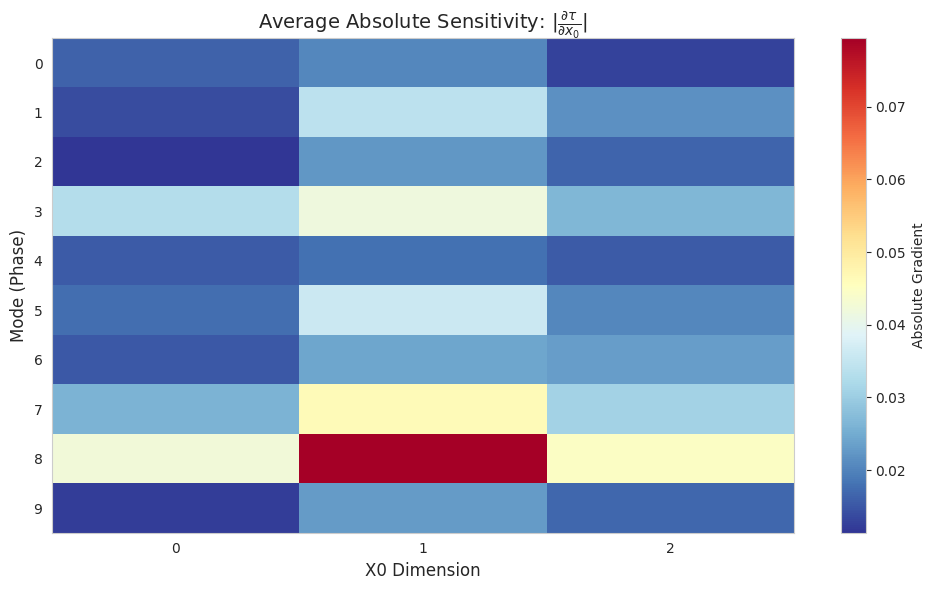


Sensitivity Statistics (averaged over all test states):
  X0 dimension 0:
  Mean sensitivity: 0.0203
  Max sensitivity:  0.0422
  Most sensitive mode: 8

  X0 dimension 1:
  Mean sensitivity: 0.0346
  Max sensitivity:  0.0794
  Most sensitive mode: 8

  X0 dimension 2:
  Mean sensitivity: 0.0229
  Max sensitivity:  0.0447
  Most sensitive mode: 8



In [30]:
# Average absolute Jacobian across all test states
avg_jac_tau = torch.abs(jacobians_tau).mean(dim=0)  # (n_phases, n_inputs)

# Plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(avg_jac_tau.numpy(), aspect='auto', cmap='RdYlBu_r')
ax.set_xlabel('X0 Dimension', fontsize=12)
ax.set_ylabel('Mode (Phase)', fontsize=12)
ax.set_title(r'Average Absolute Sensitivity: $|\frac{\partial \tau}{\partial x_0}|$', fontsize=14)
ax.set_xticks(range(N_NN_INPUTS))
ax.set_yticks(range(N_PHASES))
plt.colorbar(im, ax=ax, label='Absolute Gradient')
plt.tight_layout()
plt.grid(False)
plt.show()

# Print sensitivity statistics
print("\nSensitivity Statistics (averaged over all test states):")
print("="*60)
for input_dim in range(N_NN_INPUTS):
    sensitivity = avg_jac_tau[:, input_dim].numpy()
    print(f"  X0 dimension {input_dim}:")
    print(f"  Mean sensitivity: {sensitivity.mean():.4f}")
    print(f"  Max sensitivity:  {sensitivity.max():.4f}")
    print(f"  Most sensitive mode: {sensitivity.argmax()}")
    print()

We visualize how sensitive the control inputs are to changes in each x0 dimension.

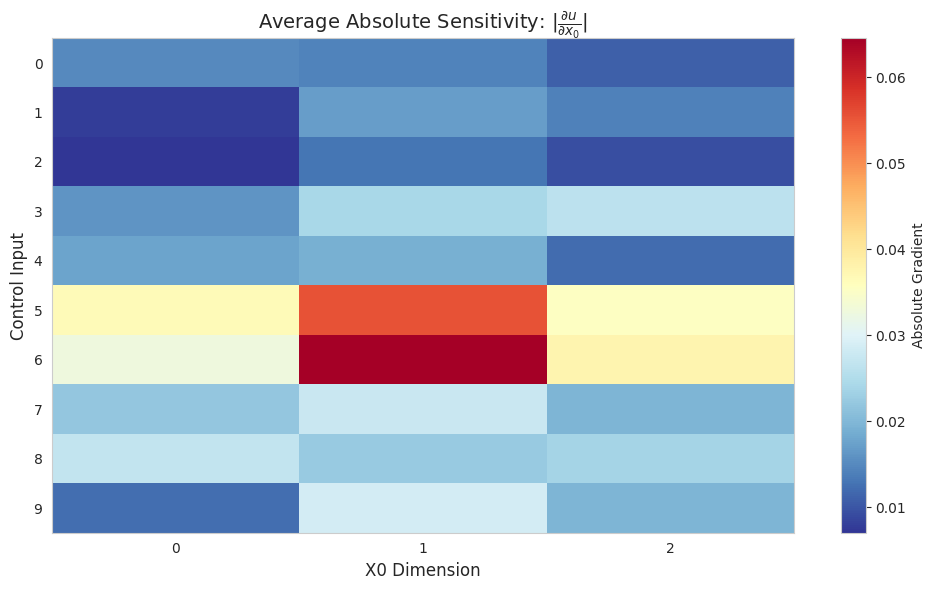


Sensitivity Statistics (averaged over all test states):
  X0 dimension 0:
  Mean sensitivity: 0.0194
  Max sensitivity:  0.0366
  Most sensitive mode: 5

  X0 dimension 1:
  Mean sensitivity: 0.0286
  Max sensitivity:  0.0645
  Most sensitive mode: 6

  X0 dimension 2:
  Mean sensitivity: 0.0209
  Max sensitivity:  0.0378
  Most sensitive mode: 6



In [31]:
# Average absolute Jacobian across all test states
avg_jac_u = torch.abs(jacobians_u).mean(dim=0)  # (n_phases, n_inputs)

# Plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(avg_jac_u.numpy(), aspect='auto', cmap='RdYlBu_r')
ax.set_xlabel('X0 Dimension', fontsize=12)
ax.set_ylabel('Control Input', fontsize=12)
ax.set_title(r'Average Absolute Sensitivity: $|\frac{\partial u}{\partial x_0}|$', fontsize=14)
ax.set_xticks(range(N_NN_INPUTS))
ax.set_yticks(range(N_PHASES))
plt.colorbar(im, ax=ax, label='Absolute Gradient')
plt.tight_layout()
plt.grid(False)
plt.show()

# Print sensitivity statistics
print("\nSensitivity Statistics (averaged over all test states):")
print("="*60)
for input_dim in range(N_NN_INPUTS):
    sensitivity = avg_jac_u[:, input_dim].numpy()
    print(f"  X0 dimension {input_dim}:")
    print(f"  Mean sensitivity: {sensitivity.mean():.4f}")
    print(f"  Max sensitivity:  {sensitivity.max():.4f}")
    print(f"  Most sensitive mode: {sensitivity.argmax()}")
    print()

## Step 3: Visualizing Hidden Layer Activations

Let's see how different neurons in hidden layers respond to specific inputs.

In [6]:
# Hook to capture activations
mlp_activations = {}

def get_mlp_activation(name):
    def hook(model, input, output):
        mlp_activations[name] = output.detach()
    return hook

# Register hooks for all Linear + ReLU combinations
trained_network.eval()
layer_idx = 0
for i, layer in enumerate(trained_network.layers):
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(get_mlp_activation(f'linear_{layer_idx}'))
        layer_idx += 1

print(f"Registered hooks for {layer_idx} linear layers")

Registered hooks for 3 linear layers


In [8]:
# Get a sample x_0
test_x_0 = torch.empty(1, N_NN_INPUTS).uniform_(-1.0, 1.0)
test_x_0 = test_x_0.to(device)

# Forward pass
with torch.no_grad():
    output = trained_network(test_x_0)
    prediction = output.argmax(dim=1).item()

print(f"\nActivations captured for layers: {list(mlp_activations.keys())}")
for name, act in mlp_activations.items():
    print(f"{name}: shape {act.shape}")


Activations captured for layers: ['linear_0', 'linear_1', 'linear_2']
linear_0: shape torch.Size([1, 10])
linear_1: shape torch.Size([1, 10])
linear_2: shape torch.Size([1, 20])


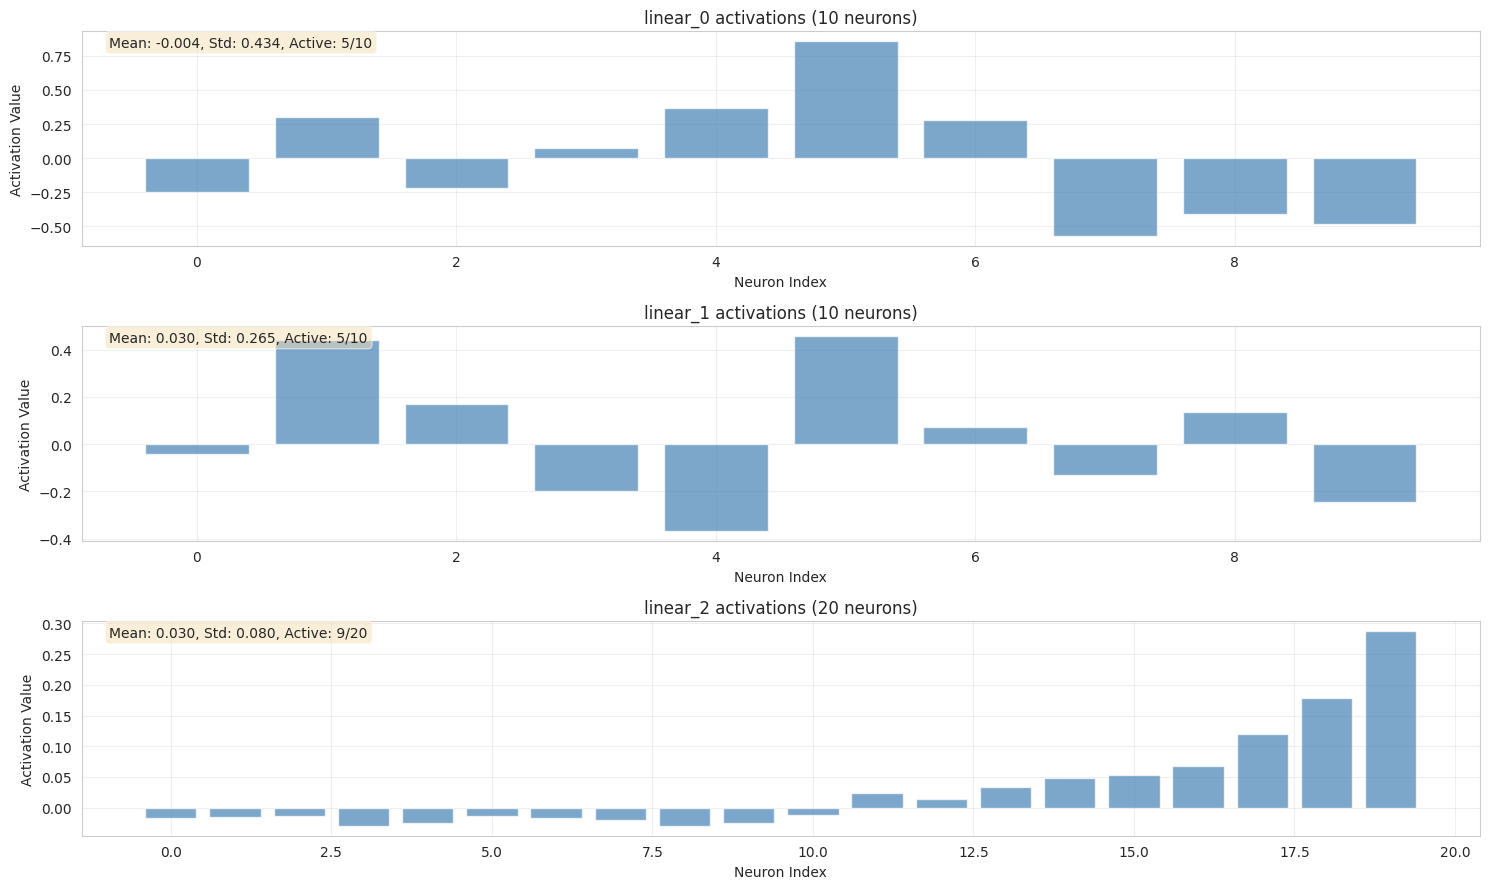

In [9]:
# Visualize activations of hidden layers
fig, axes = plt.subplots(len(mlp_activations), 1, figsize=(15, 3*len(mlp_activations)))
if len(mlp_activations) == 1:
    axes = [axes]

for idx, (layer_name, activation) in enumerate(mlp_activations.items()):
    act_values = activation[0].cpu().numpy()
    
    # Create bar plot
    axes[idx].bar(range(len(act_values)), act_values, alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{layer_name} activations ({len(act_values)} neurons)')
    axes[idx].set_xlabel('Neuron Index')
    axes[idx].set_ylabel('Activation Value')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    stats_text = f'Mean: {act_values.mean():.3f}, Std: {act_values.std():.3f}, 'f'Active: {(act_values > 0).sum()}/{len(act_values)}'
    axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

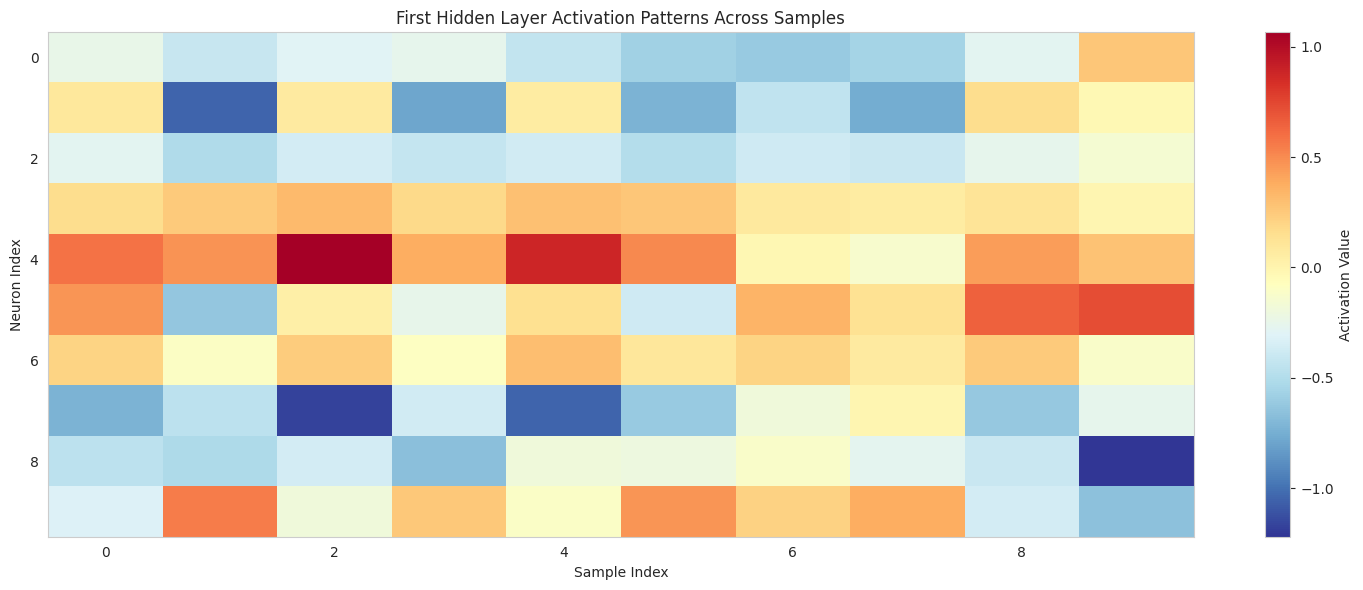

In [13]:
# Visualize activation patterns across multiple samples
n_samples = 10
# fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))

for i in range(n_samples):
    input = X_test[i:i+1].to(device)
    # label = sample_labels[i].item()
    
    with torch.no_grad():
        _ = trained_network(input)
    
    # Get first hidden layer activation
    first_layer_act = mlp_activations['linear_0'][0].cpu().numpy()
    
    # axes[i].imshow(X_test[i].squeeze(), cmap='gray')
    # axes[i].set_title(f'Label: {label}', fontsize=10)
    # axes[i].axis('off')

# plt.suptitle('Sample Inputs', fontsize=14)
# plt.tight_layout()
# plt.show()

# Plot activation heatmap for these samples
activations_matrix = []
for i in range(n_samples):
    input = X_test[i:i+1].to(device)
    with torch.no_grad():
        _ = trained_network(input)
    first_layer_act = mlp_activations['linear_0'][0].cpu().numpy()
    activations_matrix.append(first_layer_act)

activations_matrix = np.array(activations_matrix)

plt.figure(figsize=(15, 6))
plt.imshow(activations_matrix.T, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(label='Activation Value')
plt.xlabel('Sample Index')
plt.ylabel('Neuron Index')
plt.title('First Hidden Layer Activation Patterns Across Samples')
plt.grid(False)
plt.tight_layout()
plt.show()

## Technique 2: Visualizing First Layer Weights

W can visualize the weights of the first layer as "templates" that the network looks for.

First layer weight shape: (10, 3)
Each neuron has 3 weights (3 features)


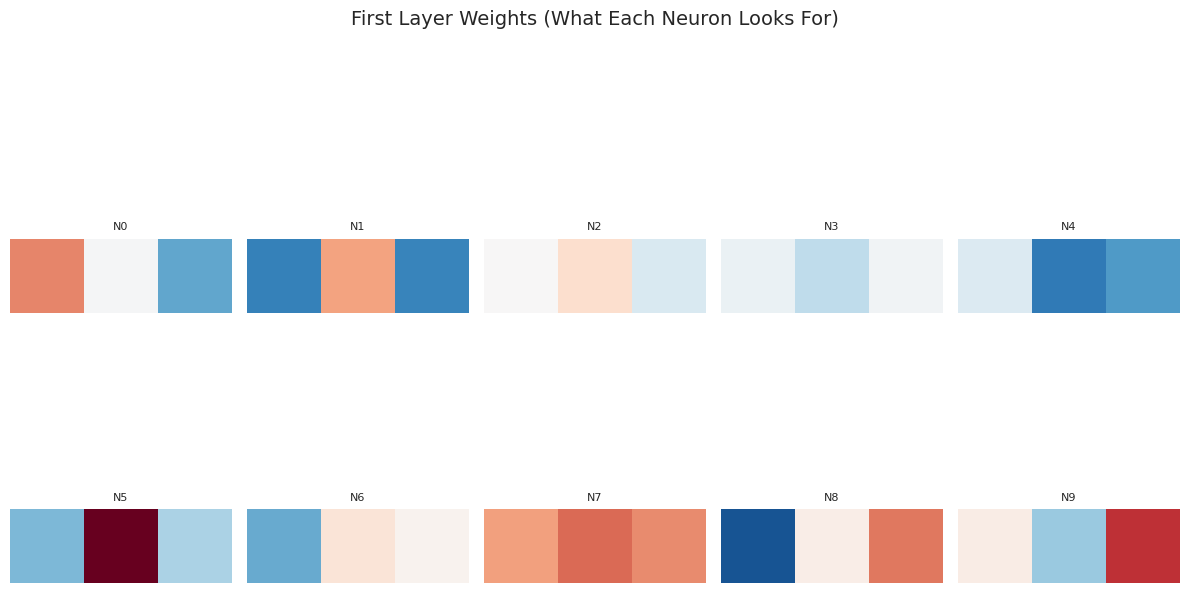

In [21]:
# Get first layer weights
first_layer = trained_network.layers[0]  # First Linear layer
weights = first_layer.weight.data.cpu().numpy()  # Shape: (hidden_size, 3)

print(f"First layer weight shape: {weights.shape}")
print(f"Each neuron has {weights.shape[1]} weights (3 features)")

# Visualize weights of first layer neurons
n_neurons_to_show = weights.shape[0]
fig, axes = plt.subplots(2, n_neurons_to_show//2)
axes = axes.flatten()

for i in range(n_neurons_to_show):
    # Reshape weight vector to image
    weight_img = weights[i].reshape(1, 3)
    
    axes[i].imshow(weight_img, cmap='RdBu_r', vmin=-weights.max(), vmax=weights.max())
    axes[i].set_title(f'N{i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle('First Layer Weights (What Each Neuron Looks For)', fontsize=14)
plt.tight_layout()
plt.show()

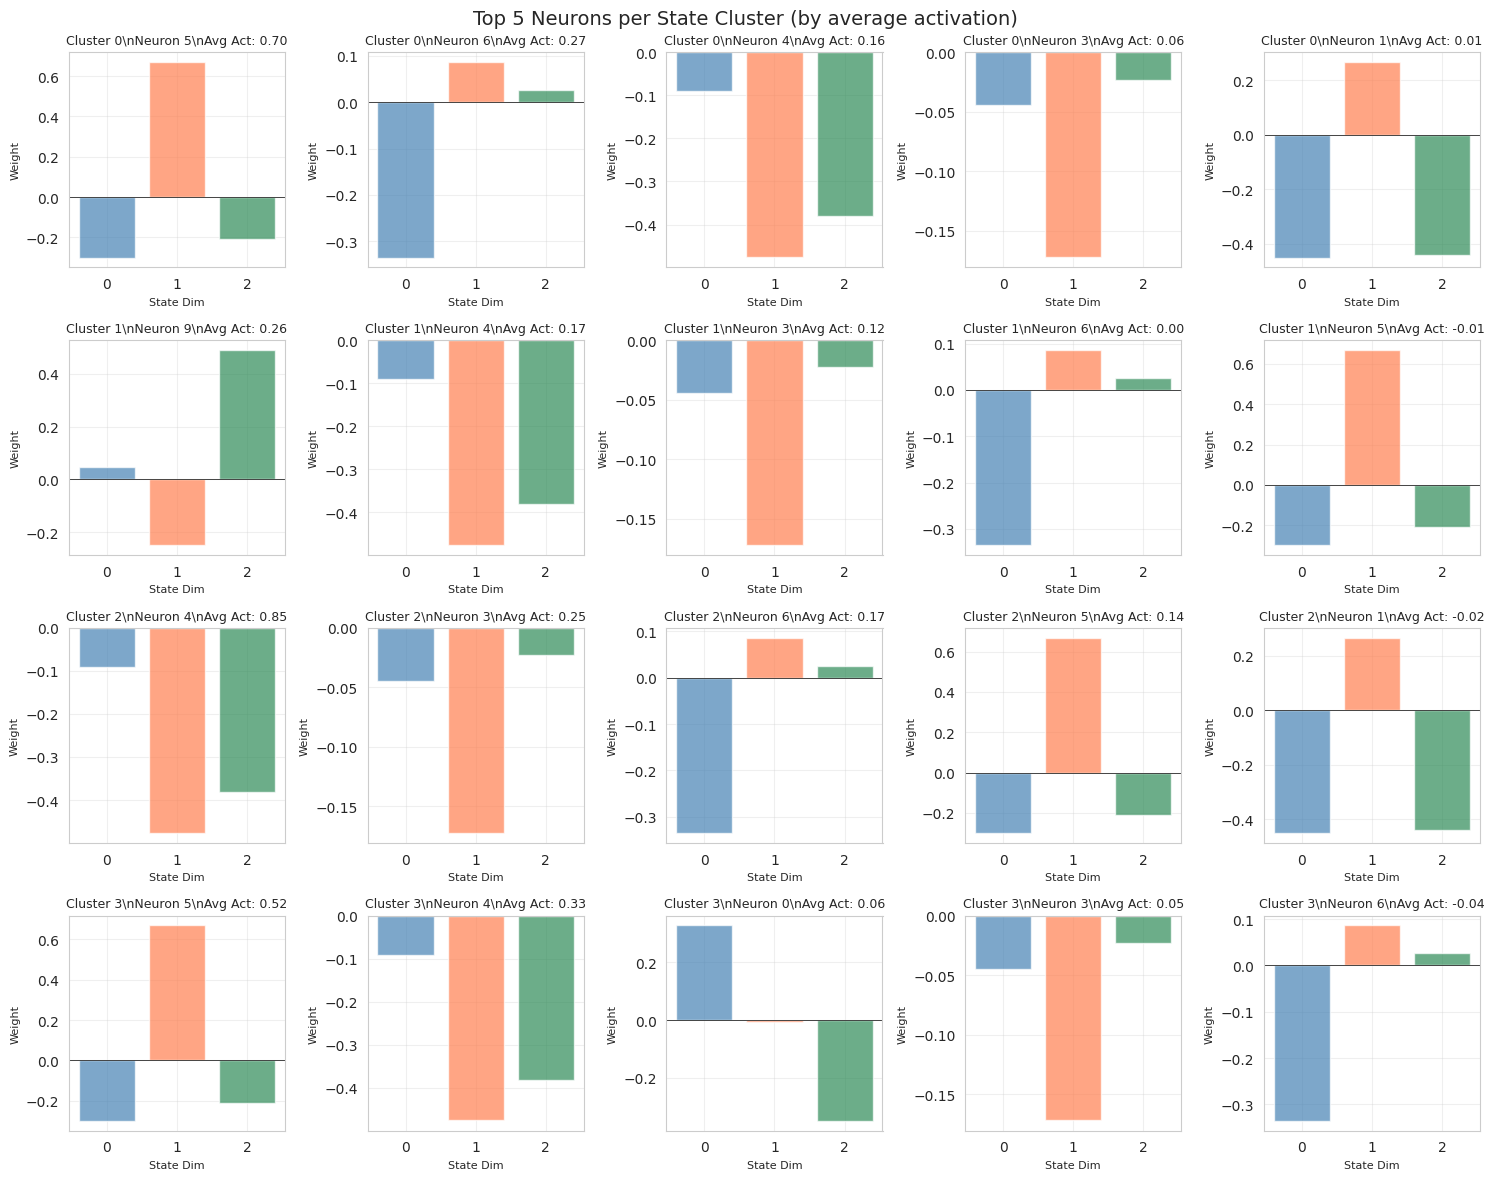


Cluster Statistics:

Cluster 0 (21 states):
  Center: [-0.433, 0.543, 0.008]
  Top neurons: [5 6 4 3 1]

Cluster 1 (39 states):
  Center: [0.256, -0.049, 0.552]
  Top neurons: [9 4 3 6 5]

Cluster 2 (24 states):
  Center: [-0.423, -0.470, -0.548]
  Top neurons: [4 3 6 5 1]

Cluster 3 (16 states):
  Center: [0.443, 0.479, -0.572]
  Top neurons: [5 4 0 3 6]


In [23]:
# Cluster test states by their characteristics (e.g., using k-means on input states)
def cluster_states_and_get_top_neurons(model, test_states, n_clusters=4, n_top=5):
    """
    Cluster test states and find neurons that activate most for each cluster.
    
    Args:
        model: The neural network
        test_states: Test state tensor (n_samples, n_inputs)
        n_clusters: Number of clusters to create
        n_top: Number of top neurons to return per cluster
    
    Returns:
        clusters: Cluster labels for each state
        top_neurons_per_cluster: Top neuron indices per cluster
        avg_activations_per_cluster: Average activations per cluster
    """
    # Cluster states using k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(test_states.cpu().numpy())
    
    # Get activations for all states
    neuron_activations = []
    with torch.no_grad():
        for state in test_states:
            state = state.unsqueeze(0).to(device)
            _ = model(state)
            
            # Get first layer activations
            act = mlp_activations['linear_0'].cpu().numpy()
            neuron_activations.append(act.squeeze())
    
    neuron_activations = np.array(neuron_activations)  # (n_samples, n_neurons)
    
    # Analyze each cluster
    top_neurons_per_cluster = []
    avg_activations_per_cluster = []
    
    for cluster_id in range(n_clusters):
        # Get states in this cluster
        cluster_mask = (clusters == cluster_id)
        cluster_activations = neuron_activations[cluster_mask]
        
        # Average activations across cluster samples
        avg_activation = cluster_activations.mean(axis=0)
        avg_activations_per_cluster.append(avg_activation)
        
        # Get top neurons
        top_indices = np.argsort(avg_activation)[-n_top:][::-1]
        top_neurons_per_cluster.append(top_indices)
    
    return clusters, top_neurons_per_cluster, avg_activations_per_cluster, kmeans.cluster_centers_

# Cluster test states and analyze neuron responses
n_clusters = 4
clusters, top_neurons_list, avg_acts_list, cluster_centers = cluster_states_and_get_top_neurons(
    trained_network, X_test, n_clusters=n_clusters, n_top=5
)

# Visualize weights of top neurons for each cluster
fig, axes = plt.subplots(n_clusters, 5, figsize=(15, 3*n_clusters))

for row, (top_neurons, avg_act, center) in enumerate(zip(top_neurons_list, avg_acts_list, cluster_centers)):
    for col, neuron_idx in enumerate(top_neurons):
        # Get weight vector for this neuron (3D)
        weight_vec = weights[neuron_idx]
        
        # Visualize as bar chart
        axes[row, col].bar(range(N_NN_INPUTS), weight_vec, alpha=0.7, 
                          color=['steelblue', 'coral', 'seagreen'][:N_NN_INPUTS])
        axes[row, col].set_title(f'Cluster {row}\\nNeuron {neuron_idx}\\nAvg Act: {avg_act[neuron_idx]:.2f}', 
                                fontsize=9)
        axes[row, col].set_xlabel('State Dim', fontsize=8)
        axes[row, col].set_ylabel('Weight', fontsize=8)
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_xticks(range(N_NN_INPUTS))
        axes[row, col].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.suptitle('Top 5 Neurons per State Cluster (by average activation)', fontsize=14)
plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
print("="*60)
for cluster_id in range(n_clusters):
    cluster_mask = (clusters == cluster_id)
    n_states = cluster_mask.sum()
    center = cluster_centers[cluster_id]
    print(f"\nCluster {cluster_id} ({n_states} states):")
    print(f"  Center: [{center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}]")
    print(f"  Top neurons: {top_neurons_list[cluster_id]}")

## Technique 3: Saliency Maps (Input Attribution)

Saliency maps show which input pixels are most important for the prediction. This is analogous to Grad-CAM but for MLPs.

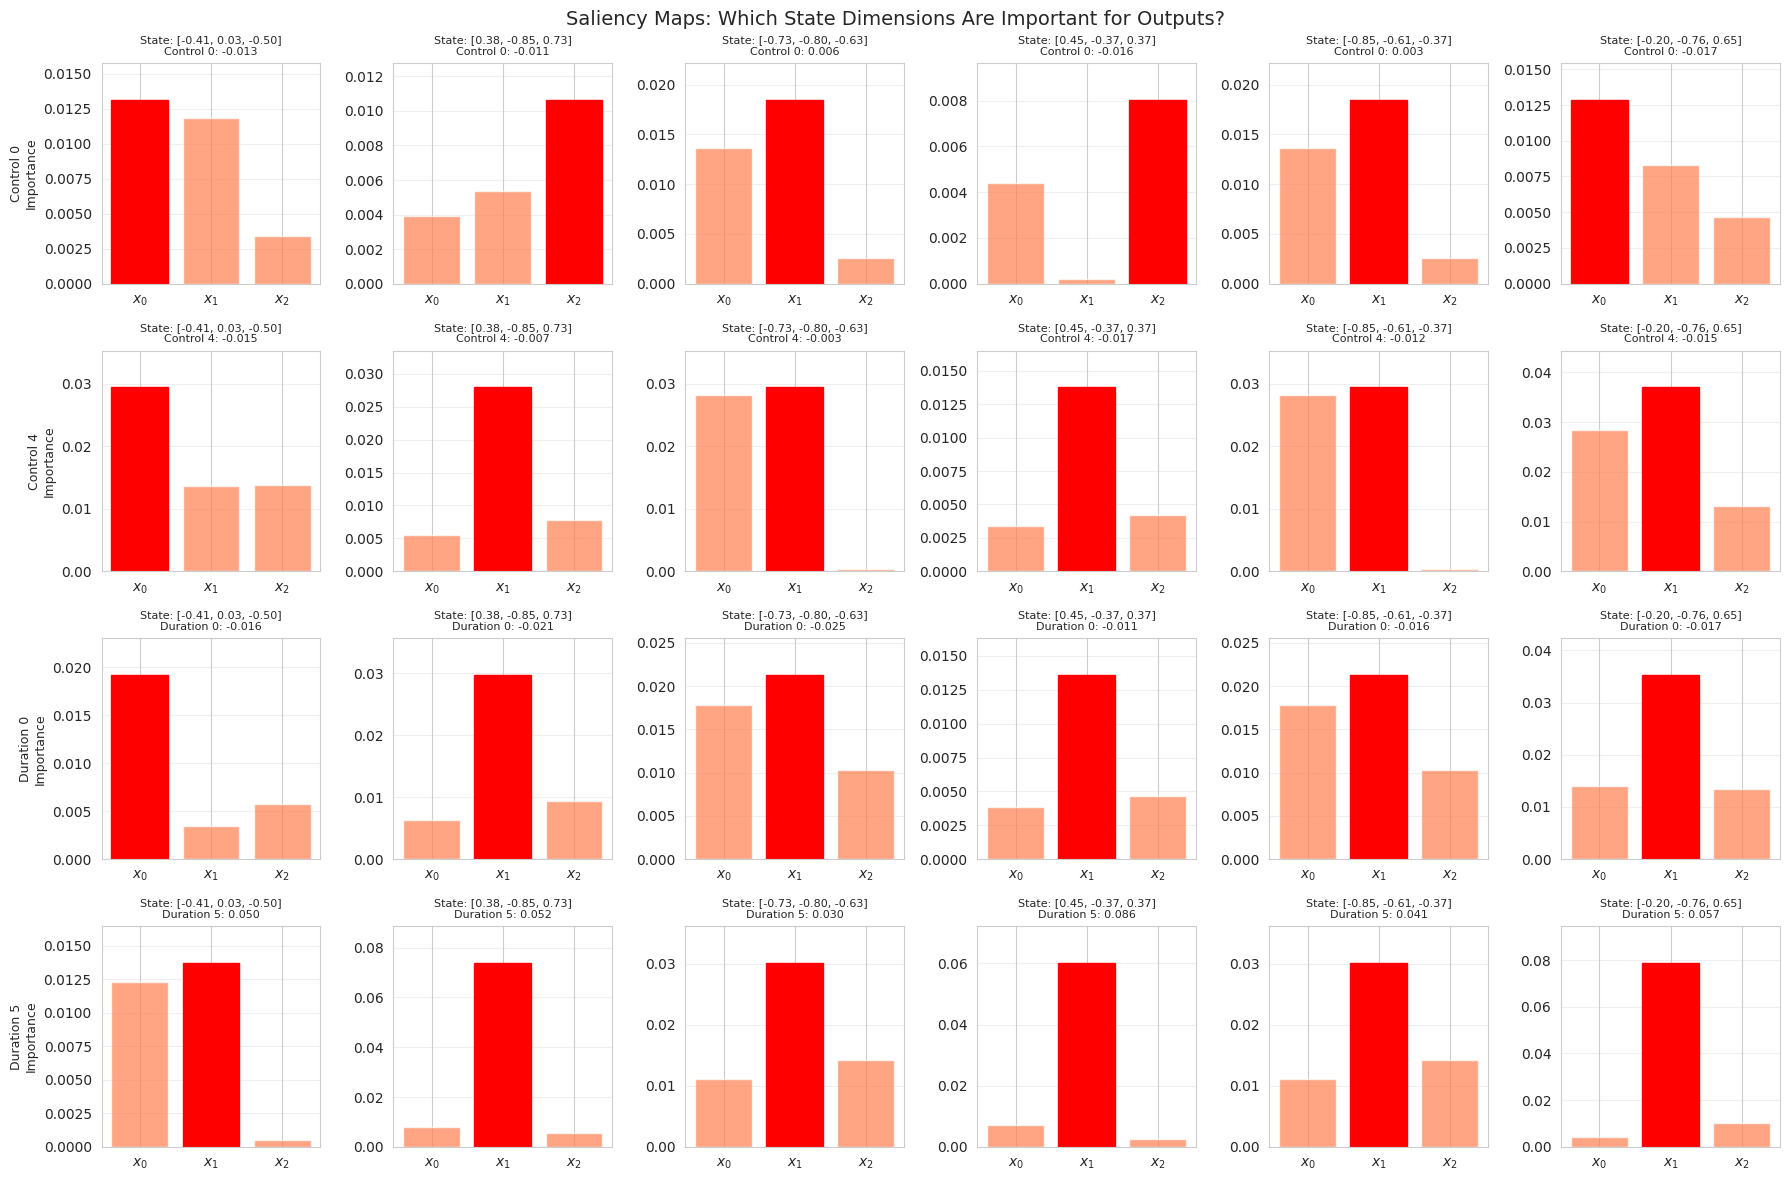


Average Saliency Analysis:

Control 0:
  State dim 0: 42.2% importance
  State dim 1: 38.0% importance
  State dim 2: 19.8% importance
  → Most important: State dimension 0

Control 4:
  State dim 0: 32.9% importance
  State dim 1: 45.2% importance
  State dim 2: 21.9% importance
  → Most important: State dimension 1

Duration 0:
  State dim 0: 33.8% importance
  State dim 1: 42.4% importance
  State dim 2: 23.7% importance
  → Most important: State dimension 1

Duration 5:
  State dim 0: 17.6% importance
  State dim 1: 55.2% importance
  State dim 2: 27.2% importance
  → Most important: State dimension 1


In [26]:
def compute_saliency_map_for_output(model, input_tensor, output_idx):
    """
    Compute saliency map showing which input dimensions affect a specific output.
    
    Args:
        model: The neural network
        input_tensor: Input state tensor (requires_grad=True)
        output_idx: Index of the output to analyze
    
    Returns:
        saliency: Gradient magnitude for each input dimension
    """
    model.eval()
    
    # Enable gradient computation for input
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    
    # Forward pass
    output = model(input_tensor)
    
    # Zero gradients
    model.zero_grad()
    
    # Backward pass for target output
    output_value = output[0, output_idx]
    output_value.backward()
    
    # Get gradient (importance of each state dimension)
    saliency = input_tensor.grad.data.abs()
    
    return saliency[0].cpu().numpy()


# Analyze saliency for control inputs and mode durations
n_samples = 6
outputs_to_analyze = [
    ('Control 0', 0),  # First control input
    ('Control 4', 4),  # Fifth control input
    ('Duration 0', N_PHASES * N_CONTROL_INPUTS),  # First mode duration
    ('Duration 5', N_PHASES * N_CONTROL_INPUTS + 5),  # Sixth mode duration
]

fig, axes = plt.subplots(len(outputs_to_analyze), n_samples, figsize=(18, 3*len(outputs_to_analyze)))

for row, (output_name, output_idx) in enumerate(outputs_to_analyze):
    for col in range(n_samples):
        # Get state
        input_state = X_test[col:col+1].to(device)
        
        # Compute saliency map
        saliency = compute_saliency_map_for_output(trained_network, input_state, output_idx)
        
        # Get actual state values and output value
        state_values = input_state[0].cpu().numpy()
        with torch.no_grad():
            output = trained_network(input_state)
            output_value = output[0, output_idx].item()
        
        # Visualize as bar chart
        x_pos = np.arange(N_NN_INPUTS)
        bars = axes[row, col].bar(x_pos, saliency, alpha=0.7, color='coral')
        axes[row, col].set_ylim([0, max(saliency) * 1.2 if max(saliency) > 0 else 1.0])
        axes[row, col].set_xticks(x_pos)
        axes[row, col].set_xticklabels([f'$x_{{{i}}}$' for i in range(N_NN_INPUTS)])
        axes[row, col].grid(True, alpha=0.3, axis='y')
        
        # Add state values as text
        state_text = f'State: [{state_values[0]:.2f}, {state_values[1]:.2f}, {state_values[2]:.2f}]'
        output_text = f'{output_name}: {output_value:.3f}'
        axes[row, col].set_title(f'{state_text}\n{output_text}', fontsize=8)
        
        if col == 0:
            axes[row, col].set_ylabel(f'{output_name}\nImportance', fontsize=9)
        
        # Highlight most important dimension
        max_idx = np.argmax(saliency)
        bars[max_idx].set_color('red')
        bars[max_idx].set_alpha(1.0)

plt.suptitle('Saliency Maps: Which State Dimensions Are Important for Outputs?', fontsize=14)
plt.tight_layout()
plt.show()

# Compute average saliency across all test states
print("\nAverage Saliency Analysis:")
print("="*60)

for output_name, output_idx in outputs_to_analyze:
    saliencies = []
    for state in X_test[:20]:  # Use subset for efficiency
        sal = compute_saliency_map_for_output(trained_network, state.unsqueeze(0).to(device), output_idx)
        saliencies.append(sal)
    
    avg_saliency = np.array(saliencies).mean(axis=0)
    normalized_saliency = avg_saliency / avg_saliency.sum()
    
    print(f"\n{output_name}:")
    for i in range(N_NN_INPUTS):
        print(f"  State dim {i}: {normalized_saliency[i]*100:.1f}% importance")
    most_important = np.argmax(normalized_saliency)
    print(f"  → Most important: State dimension {most_important}")

## Technique 4: Neuron Maximization (Input Synthesis)

Find inputs that maximally activate specific neurons in the network. This is analogous to filter visualization for CNNs.

Generating states that maximally activate specific neurons...
Total neurons in first layer: 10
  Neuron 0...
  Neuron 1...
  Neuron 2...
  Neuron 3...
  Neuron 5...
  Neuron 6...
  Neuron 7...
  Neuron 9...


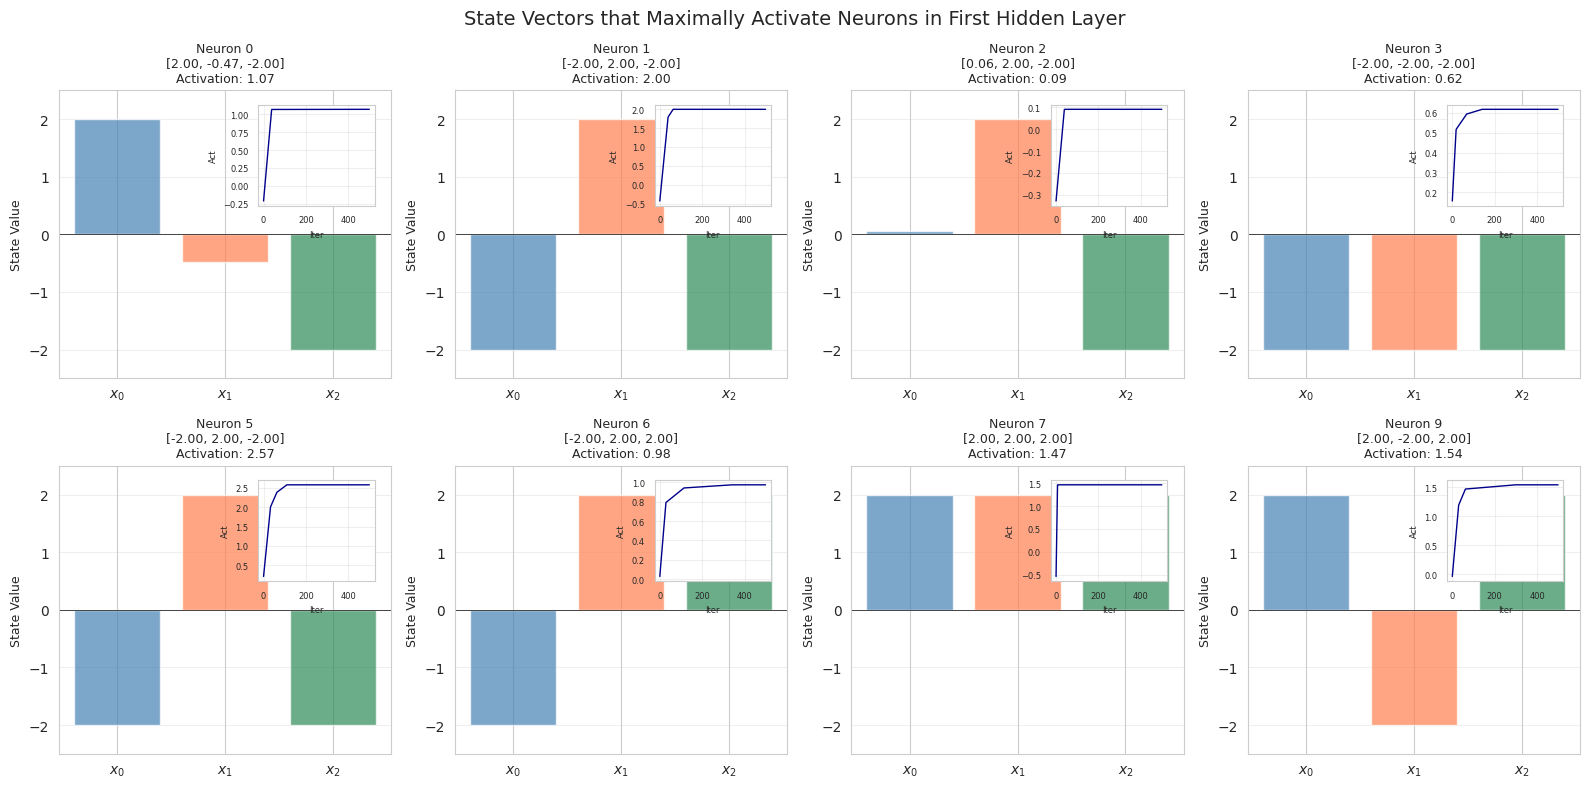

In [29]:
def maximize_neuron_activation(model, layer_idx, neuron_index, iterations=500, lr=0.05):
    """
    Generate an input state that maximally activates a specific neuron.
    
    Args:
        model: The neural network
        layer_idx: Index of the layer (0 for first hidden layer)
        neuron_index: Index of the neuron to maximize
        iterations: Number of gradient ascent steps
        lr: Learning rate
    
    Returns:
        optimized_input: 3D state vector that maximizes neuron activation
    """
    # Initialize random input
    optimized_input = torch.randn(1, N_NN_INPUTS, device=device) * 0.1
    optimized_input.requires_grad_(True)
    
    model.eval()
    
    activation_history = []
    
    for i in range(iterations):
        # Zero gradients
        if optimized_input.grad is not None:
            optimized_input.grad.zero_()
        
        # Forward pass through first layer only
        x = optimized_input
        for idx, layer in enumerate(model.layers):
            x = layer(x)
            if idx == layer_idx * 2:  # After linear layer (before ReLU)
                # Get activation of target neuron
                activation = x[0, neuron_index]
                activation_history.append(activation.item())
                
                # Backward pass
                activation.backward()
                break
        
        # Gradient ascent step
        with torch.no_grad():
            # Normalize gradient to prevent explosion
            grad = optimized_input.grad / (optimized_input.grad.std() + 1e-8)
            optimized_input += lr * grad
            
            # Clip to reasonable state space range
            optimized_input.clamp_(-2, 2)
    
    return optimized_input.detach()[0].cpu().numpy(), activation_history


# Maximize activation for neurons in first hidden layer
n_neurons = trained_network.layers[0].out_features
neurons_to_visualize = np.linspace(0, n_neurons-1, 8, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

print("Generating states that maximally activate specific neurons...")
print(f"Total neurons in first layer: {n_neurons}")

for idx, neuron_idx in enumerate(neurons_to_visualize):
    print(f"  Neuron {neuron_idx}...")
    max_state, act_history = maximize_neuron_activation(trained_network, 0, neuron_idx, 
                                                        iterations=500, lr=0.05)
    
    # Plot 1: State as bar chart
    ax = axes[idx]
    bars = ax.bar(range(N_NN_INPUTS), max_state, alpha=0.7, 
                  color=['steelblue', 'coral', 'seagreen'][:N_NN_INPUTS])
    ax.set_ylim([-2.5, 2.5])
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xticks(range(N_NN_INPUTS))
    ax.set_xticklabels([f'$x_{{{i}}}$' for i in range(N_NN_INPUTS)])
    ax.set_ylabel('State Value', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add final activation value
    final_activation = act_history[-1]
    state_str = f'[{max_state[0]:.2f}, {max_state[1]:.2f}, {max_state[2]:.2f}]'
    ax.set_title(f'Neuron {neuron_idx}\n{state_str}\nActivation: {final_activation:.2f}', fontsize=9)
    
    # Add small inset showing activation history
    ax_inset = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
    ax_inset.plot(act_history, linewidth=1, color='darkblue')
    ax_inset.set_xlabel('Iter', fontsize=6)
    ax_inset.set_ylabel('Act', fontsize=6)
    ax_inset.tick_params(labelsize=6)
    ax_inset.grid(True, alpha=0.3)

plt.suptitle('State Vectors that Maximally Activate Neurons in First Hidden Layer', fontsize=14)
plt.tight_layout()
plt.show()

# 📊 Comprehensive Interpretability Dashboard

Summary visualization combining all analysis techniques applied to the SwiLinNN policy network.

/home/pietro/data-driven/learning_optimization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pietro/data-driven/learning_optimization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


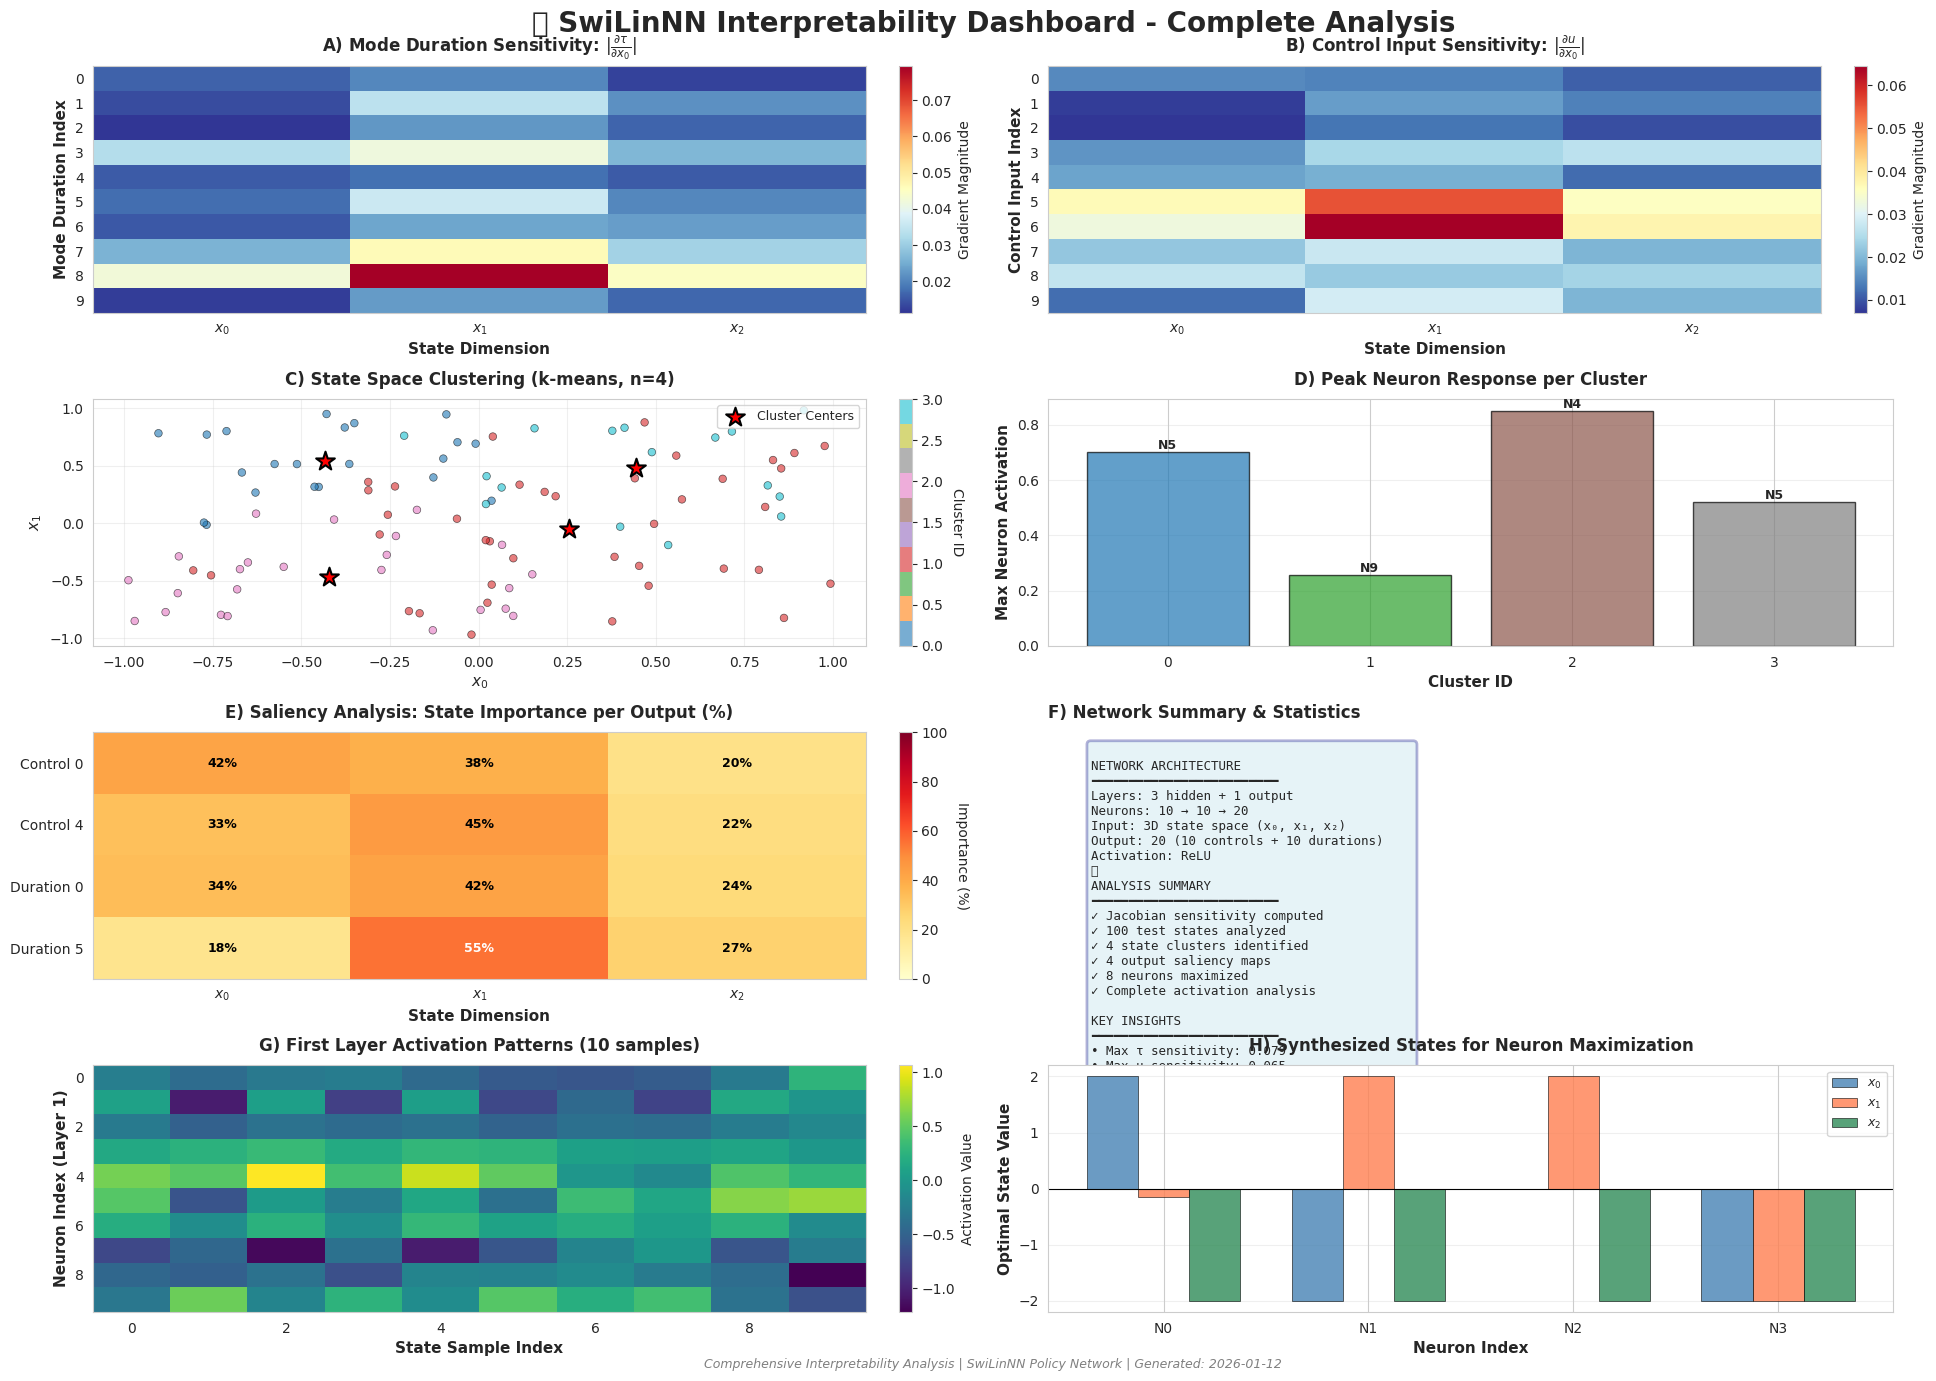


📊 DASHBOARD GENERATED SUCCESSFULLY
✓ 8 analysis panels created
✓ 100 states analyzed across all techniques
✓ Combined insights from Jacobian, saliency, clustering, and activation analyses


In [ ]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3, top=0.94, bottom=0.05, left=0.05, right=0.95)

# Title
fig.suptitle('🧠 SwiLinNN Interpretability Dashboard - Complete Analysis', 
             fontsize=20, fontweight='bold', y=0.98)

# ============================================================================
# Panel 1: Sensitivity Heatmaps (2 columns)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :2])
im1 = ax1.imshow(avg_jac_tau.numpy(), aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
ax1.set_xlabel('State Dimension', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mode Duration Index', fontsize=11, fontweight='bold')
ax1.set_title('A) Mode Duration Sensitivity: $|\\frac{\\partial \\tau}{\\partial x_0}|$', 
              fontsize=12, fontweight='bold', pad=10)
ax1.set_xticks(range(N_NN_INPUTS))
ax1.set_xticklabels([f'$x_{{{i}}}$' for i in range(N_NN_INPUTS)])
ax1.set_yticks(range(N_PHASES))
plt.colorbar(im1, ax=ax1, label='Gradient Magnitude', fraction=0.046, pad=0.04)
ax1.grid(False)

ax2 = fig.add_subplot(gs[0, 2:])
im2 = ax2.imshow(avg_jac_u.numpy(), aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
ax2.set_xlabel('State Dimension', fontsize=11, fontweight='bold')
ax2.set_ylabel('Control Input Index', fontsize=11, fontweight='bold')
ax2.set_title('B) Control Input Sensitivity: $|\\frac{\\partial u}{\\partial x_0}|$', 
              fontsize=12, fontweight='bold', pad=10)
ax2.set_xticks(range(N_NN_INPUTS))
ax2.set_xticklabels([f'$x_{{{i}}}$' for i in range(N_NN_INPUTS)])
ax2.set_yticks(range(N_PHASES))
plt.colorbar(im2, ax=ax2, label='Gradient Magnitude', fraction=0.046, pad=0.04)
ax2.grid(False)

# ============================================================================
# Panel 2: Cluster Analysis
# ============================================================================
ax3 = fig.add_subplot(gs[1, :2])
# Create cluster scatter plot in 3D projected to 2D
X_test_np = X_test.cpu().numpy()
scatter = ax3.scatter(X_test_np[:, 0], X_test_np[:, 1], c=clusters, 
                     cmap='tab10', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
# Plot cluster centers
ax3.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
           c='red', s=200, marker='*', edgecolors='k', linewidth=1.5,
           label='Cluster Centers', zorder=10)
ax3.set_xlabel('$x_0$', fontsize=11, fontweight='bold')
ax3.set_ylabel('$x_1$', fontsize=11, fontweight='bold')
ax3.set_title('C) State Space Clustering (k-means, n=4)', 
              fontsize=12, fontweight='bold', pad=10)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_label('Cluster ID', rotation=270, labelpad=15)

# Panel 3: Top neurons per cluster (compact view)
ax4 = fig.add_subplot(gs[1, 2:])
# Create a summary bar chart showing top neuron activations per cluster
cluster_neuron_data = []
for cluster_id in range(n_clusters):
    top_neuron = top_neurons_list[cluster_id][0]  # Get top neuron
    avg_activation = avg_acts_list[cluster_id][top_neuron]
    cluster_neuron_data.append((cluster_id, top_neuron, avg_activation))

cluster_ids = [d[0] for d in cluster_neuron_data]
neuron_ids = [d[1] for d in cluster_neuron_data]
activations = [d[2] for d in cluster_neuron_data]

colors_cluster = plt.cm.tab10(np.array(cluster_ids) / n_clusters)
bars = ax4.bar(cluster_ids, activations, color=colors_cluster, alpha=0.7, edgecolor='k', linewidth=1)
ax4.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax4.set_ylabel('Max Neuron Activation', fontsize=11, fontweight='bold')
ax4.set_title('D) Peak Neuron Response per Cluster', 
              fontsize=12, fontweight='bold', pad=10)
ax4.set_xticks(cluster_ids)
ax4.grid(True, alpha=0.3, axis='y')

# Add neuron labels on bars
for i, (bar, neuron_id) in enumerate(zip(bars, neuron_ids)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'N{neuron_id}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# Panel 4: Saliency Analysis Summary
# ============================================================================
ax5 = fig.add_subplot(gs[2, :2])
# Compute average saliency across all outputs
saliency_summary = []
for output_name, output_idx in outputs_to_analyze:
    saliencies = []
    for state in X_test[:20]:
        sal = compute_saliency_map_for_output(trained_network, state.unsqueeze(0).to(device), output_idx)
        saliencies.append(sal)
    avg_sal = np.array(saliencies).mean(axis=0)
    saliency_summary.append(avg_sal / avg_sal.sum() * 100)  # Percentage

saliency_matrix = np.array(saliency_summary)
im5 = ax5.imshow(saliency_matrix, aspect='auto', cmap='YlOrRd', vmin=0, vmax=100)
ax5.set_yticks(range(len(outputs_to_analyze)))
ax5.set_yticklabels([name for name, _ in outputs_to_analyze], fontsize=10)
ax5.set_xticks(range(N_NN_INPUTS))
ax5.set_xticklabels([f'$x_{{{i}}}$' for i in range(N_NN_INPUTS)], fontsize=10)
ax5.set_xlabel('State Dimension', fontsize=11, fontweight='bold')
ax5.set_title('E) Saliency Analysis: State Importance per Output (%)', 
              fontsize=12, fontweight='bold', pad=10)
cbar5 = plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
cbar5.set_label('Importance (%)', rotation=270, labelpad=15)

# Add percentage labels
for i in range(len(outputs_to_analyze)):
    for j in range(N_NN_INPUTS):
        text = ax5.text(j, i, f'{saliency_matrix[i, j]:.0f}%',
                       ha="center", va="center", color="white" if saliency_matrix[i, j] > 50 else "black",
                       fontsize=9, fontweight='bold')
ax5.grid(False)

# ============================================================================
# Panel 5: Network Architecture Summary
# ============================================================================
ax6 = fig.add_subplot(gs[2, 2:])
ax6.axis('off')
ax6.set_xlim(0, 10)
ax6.set_ylim(0, 10)

# Architecture info
arch_text = f"""
NETWORK ARCHITECTURE
━━━━━━━━━━━━━━━━━━━━━━━━━
Layers: {len([l for l in trained_network.layers if isinstance(l, nn.Linear)])} hidden + 1 output
Neurons: {' → '.join([str(l.out_features) for l in trained_network.layers if isinstance(l, nn.Linear)])}
Input: {N_NN_INPUTS}D state space (x₀, x₁, x₂)
Output: {N_NN_OUTPUTS} ({N_PHASES} controls + {N_PHASES} durations)
Activation: ReLU

ANALYSIS SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Jacobian sensitivity computed
✓ {n_test_states} test states analyzed
✓ {n_clusters} state clusters identified
✓ {len(outputs_to_analyze)} output saliency maps
✓ {len(neurons_to_visualize)} neurons maximized
✓ Complete activation analysis

KEY INSIGHTS
━━━━━━━━━━━━━━━━━━━━━━━━━
• Max τ sensitivity: {avg_jac_tau.max():.3f}
• Max u sensitivity: {avg_jac_u.max():.3f}
• Active neurons: {(weights != 0).sum()}/{weights.size} connections
• Cluster balance: {[f'{(clusters==i).sum()}' for i in range(n_clusters)]}
"""

ax6.text(0.5, 9.5, arch_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', 
        alpha=0.3, edgecolor='navy', linewidth=2))
ax6.set_title('F) Network Summary & Statistics', 
              fontsize=12, fontweight='bold', pad=10, loc='left')

# ============================================================================
# Panel 6: Activation Patterns
# ============================================================================
ax7 = fig.add_subplot(gs[3, :2])
# Show activation heatmap for sample states
sample_activations = activations_matrix[:10]  # First 10 samples
im7 = ax7.imshow(sample_activations.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax7.set_xlabel('State Sample Index', fontsize=11, fontweight='bold')
ax7.set_ylabel('Neuron Index (Layer 1)', fontsize=11, fontweight='bold')
ax7.set_title('G) First Layer Activation Patterns (10 samples)', 
              fontsize=12, fontweight='bold', pad=10)
cbar7 = plt.colorbar(im7, ax=ax7, label='Activation Value', fraction=0.046, pad=0.04)
ax7.grid(False)

# ============================================================================
# Panel 7: Neuron Maximization Examples
# ============================================================================
ax8 = fig.add_subplot(gs[3, 2:])
# Show a few maximized states
n_show = 4
neurons_subset = neurons_to_visualize[:n_show]
x_positions = np.arange(n_show)
width = 0.25

# Compute maximized states for these neurons
max_states = []
for neuron_idx in neurons_subset:
    max_state, _ = maximize_neuron_activation(trained_network, 0, neuron_idx, 
                                              iterations=200, lr=0.05)
    max_states.append(max_state)

max_states = np.array(max_states)

# Group bars by state dimension
for dim in range(N_NN_INPUTS):
    offset = (dim - 1) * width
    colors = ['steelblue', 'coral', 'seagreen'][dim]
    ax8.bar(x_positions + offset, max_states[:, dim], width, 
           label=f'$x_{{{dim}}}$', alpha=0.8, color=colors, edgecolor='k', linewidth=0.5)

ax8.set_xlabel('Neuron Index', fontsize=11, fontweight='bold')
ax8.set_ylabel('Optimal State Value', fontsize=11, fontweight='bold')
ax8.set_title('H) Synthesized States for Neuron Maximization', 
              fontsize=12, fontweight='bold', pad=10)
ax8.set_xticks(x_positions)
ax8.set_xticklabels([f'N{n}' for n in neurons_subset])
ax8.legend(loc='upper right', fontsize=9)
ax8.grid(True, alpha=0.3, axis='y')
ax8.axhline(y=0, color='k', linestyle='-', linewidth=0.8)

# ============================================================================
# Final touches
# ============================================================================
# Add a watermark/footer
fig.text(0.5, 0.01, 
        'Comprehensive Interpretability Analysis | SwiLinNN Policy Network | Generated: 2026-01-12',
        ha='center', fontsize=9, style='italic', color='gray')

plt.show()

print("\n" + "="*80)
print("📊 DASHBOARD GENERATED SUCCESSFULLY")
print("="*80)
print(f"✓ 8 analysis panels created")
print(f"✓ {n_test_states} states analyzed across all techniques")
print(f"✓ Combined insights from Jacobian, saliency, clustering, and activation analyses")
print("="*80)